In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_excel("../Apoyo-Desafio/house_data.xlsx")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:

# Exploración Inicial
print("Cantidad de registros y columnas:", df.shape)
print("\nTipos de datos en cada columna:\n", df.dtypes)
print("\nValores faltantes por columna:\n", df.isnull().sum())
print("\nCantidad de duplicados:", df.duplicated().sum())

# Convertir columnas a tipo numérico si es necesario
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Manejo de Valores Faltantes
# Imputar valores faltantes con la mediana para columnas numéricas
for column in df.select_dtypes(include=[np.number]).columns:
    df[column].fillna(df[column].median(), inplace=True)

# Eliminar filas duplicadas
df.drop_duplicates(inplace=True)

# Detección y Manejo de Valores Atípicos (Outliers)
# Usar el método del rango intercuartílico (IQR)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Filtrar outliers
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Mostrar la diferencia en el dataset antes y después de la limpieza
print("\nDataset después de la limpieza:")
print("Cantidad de registros y columnas:", df.shape)
print("\nValores faltantes por columna:\n", df.isnull().sum())
print("\nCantidad de duplicados:", df.duplicated().sum())

Cantidad de registros y columnas: (21613, 21)

Tipos de datos en cada columna:
 id                 int64
date              object
price              int64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Valores faltantes por columna:
 id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long  

C:\Users\marti\AppData\Local\Temp\ipykernel_23840\3374502237.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].median(), inplace=True)
d:\Data-Science\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\marti\AppData\Local\Temp\ipykernel_23840\3374502237.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace metho

Estadísticas descriptivas:
                  id  date         price      bedrooms     bathrooms  \
count  1.493500e+04   0.0  1.493500e+04  14935.000000  14935.000000   
mean   4.729214e+09   NaN  4.386515e+05      3.262337      1.972179   
std    2.851519e+09   NaN  1.805506e+05      0.772942      0.646058   
min    2.800031e+06   NaN  8.200000e+04      2.000000      0.750000   
25%    2.321300e+09   NaN  3.000000e+05      3.000000      1.500000   
50%    4.037800e+09   NaN  4.050000e+05      3.000000      2.000000   
75%    7.453500e+09   NaN  5.475000e+05      4.000000      2.500000   
max    9.900000e+09   NaN  1.130000e+06      5.000000      3.500000   

        sqft_living      sqft_lot        floors  waterfront     view  ...  \
count  14935.000000  14935.000000  14935.000000     14935.0  14935.0  ...   
mean    1814.293940   6988.896150      1.471342         0.0      0.0  ...   
std      614.767257   3355.737263      0.547908         0.0      0.0  ...   
min      560.000000    5

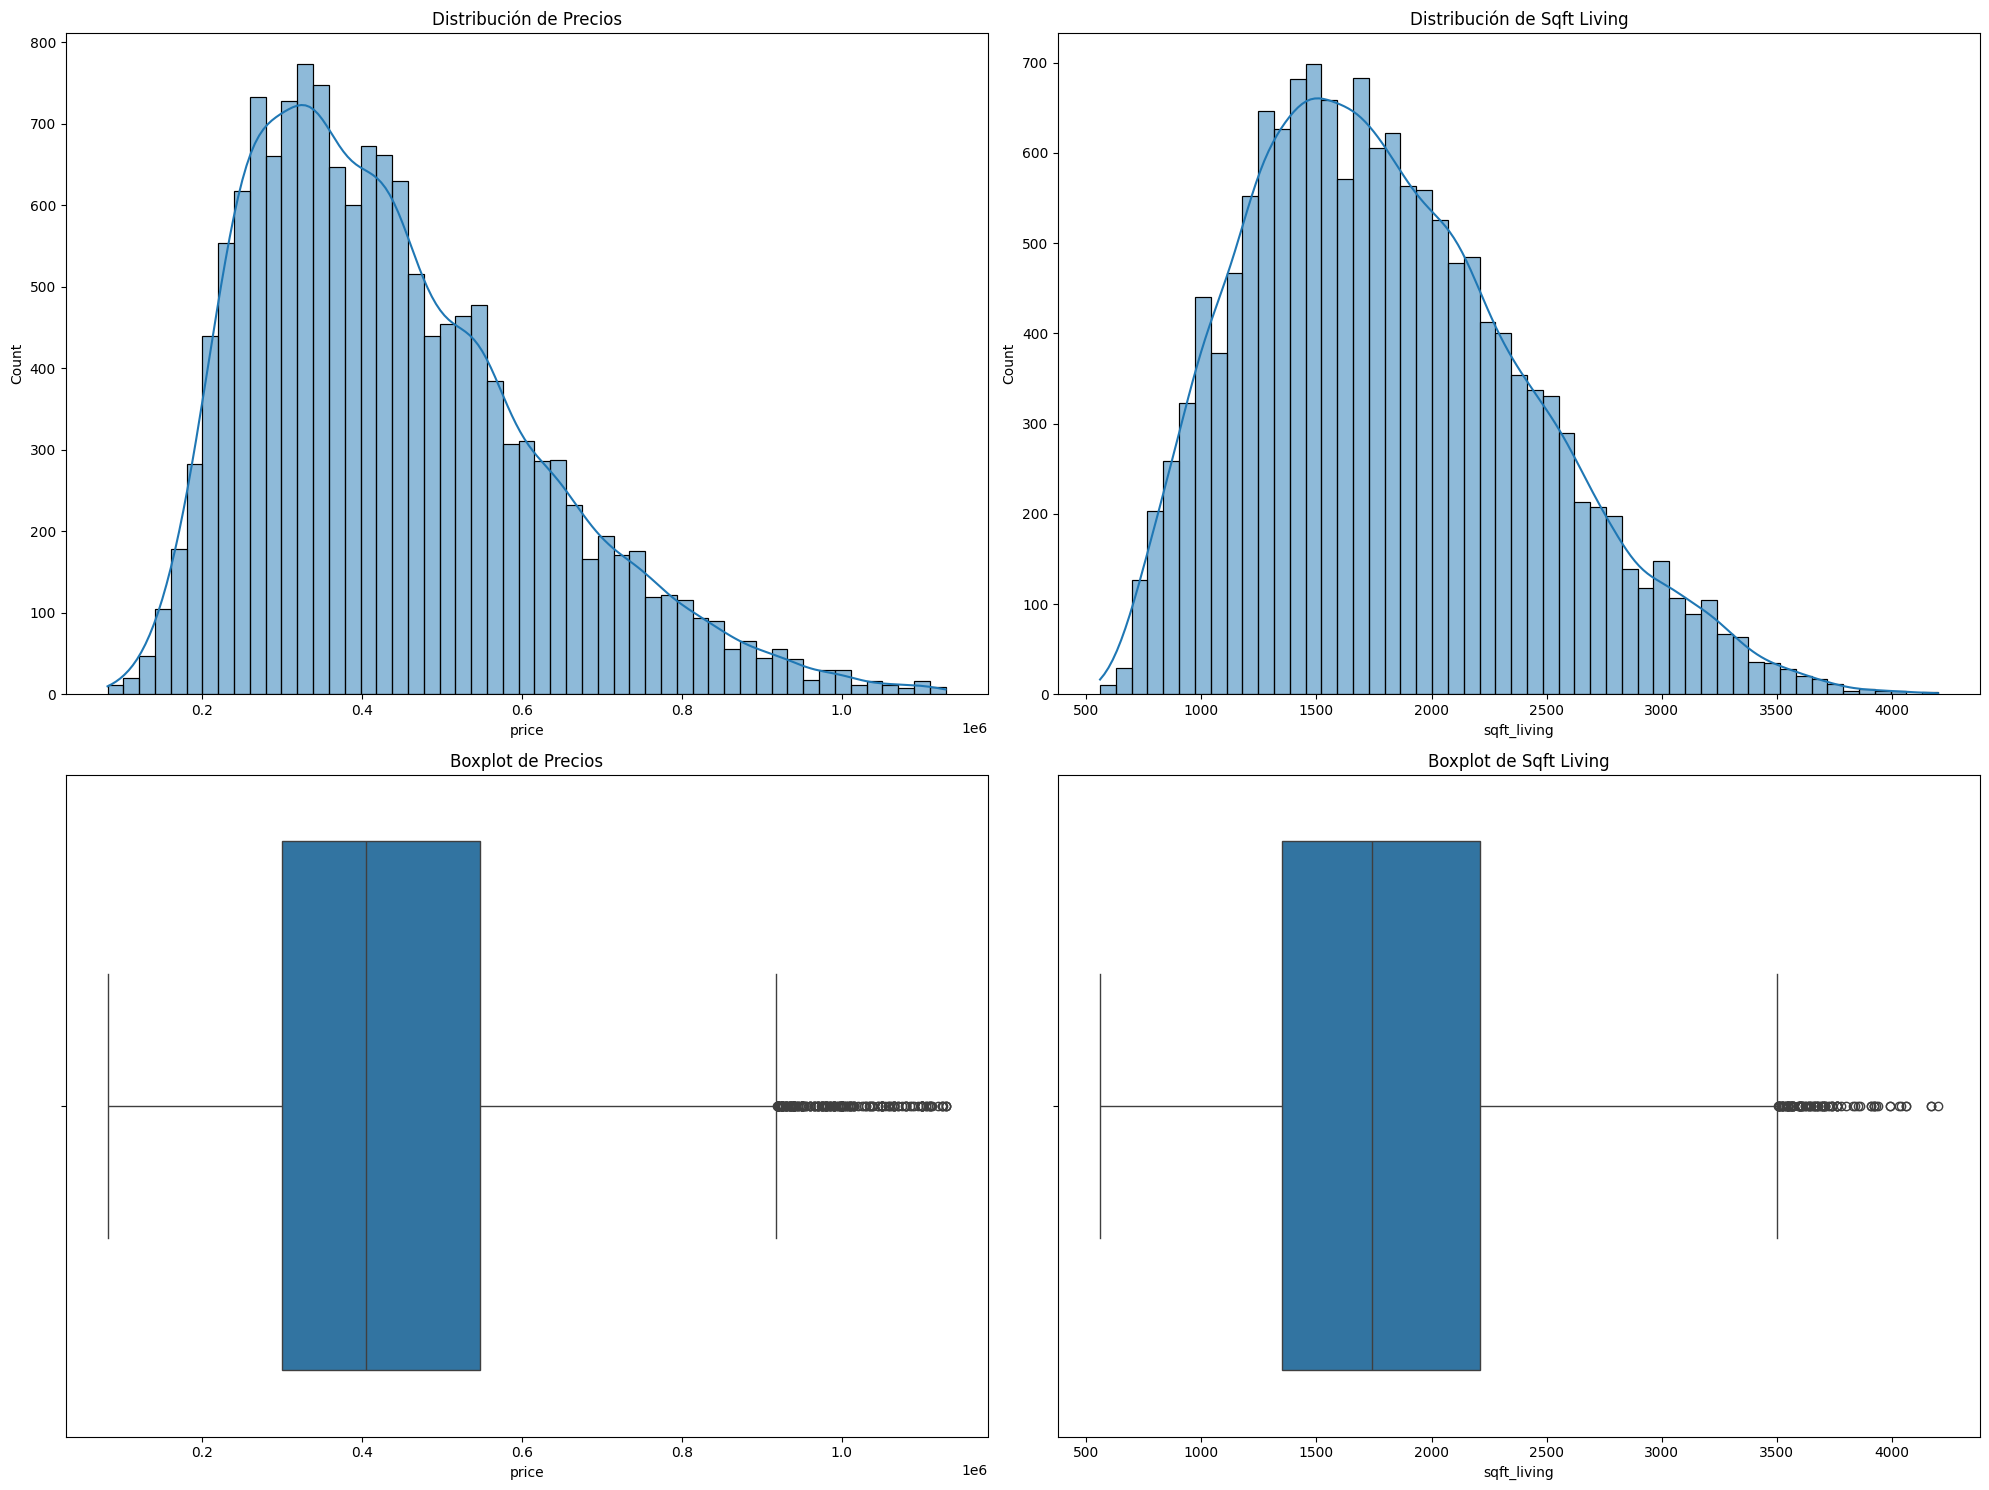

Matriz de correlaciones:
                      id     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
id             1.000000  0.040555  0.005133   0.043069     0.045742 -0.051644   
price          0.040555  1.000000  0.240281   0.340540     0.514756 -0.085262   
bedrooms       0.005133  0.240281  1.000000   0.443847     0.614699  0.204914   
bathrooms      0.043069  0.340540  0.443847   1.000000     0.669382 -0.088657   
sqft_living    0.045742  0.514756  0.614699   0.669382     1.000000  0.164707   
sqft_lot      -0.051644 -0.085262  0.204914  -0.088657     0.164707  1.000000   
floors         0.030931  0.227670  0.129223   0.524506     0.317602 -0.416314   
waterfront          NaN       NaN       NaN        NaN          NaN       NaN   
view                NaN       NaN       NaN        NaN          NaN       NaN   
condition     -0.035253  0.085759  0.029577  -0.157311    -0.067761  0.150807   
grade          0.057319  0.528086  0.290615   0.584209     0.622820 -0.031971   
sq

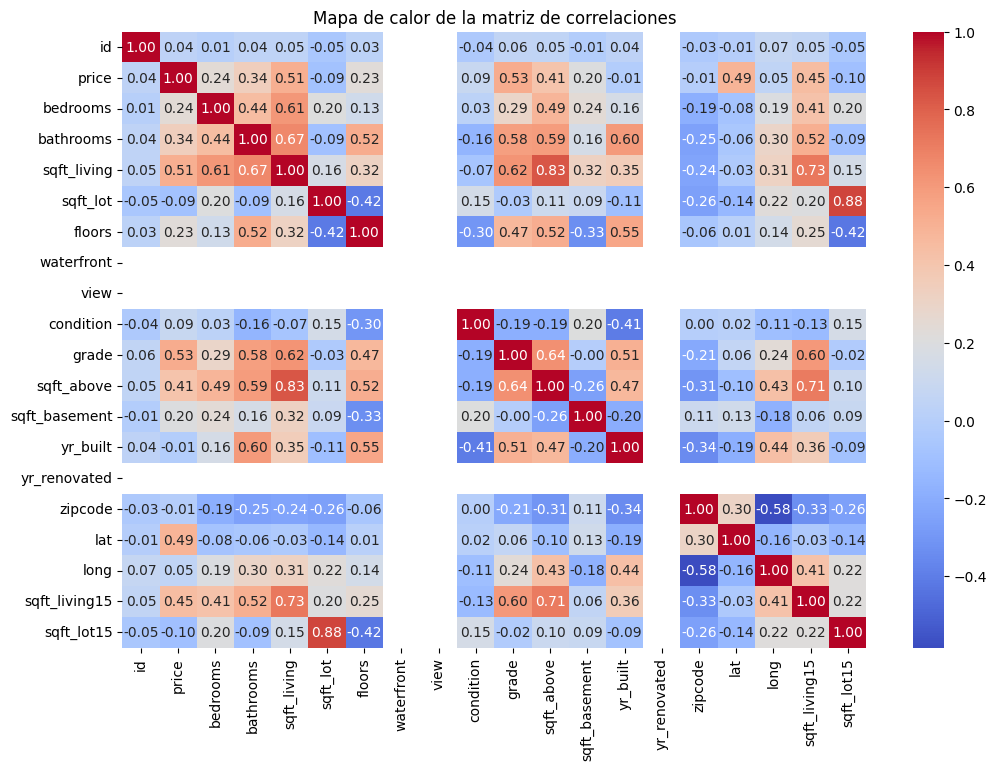

Correlación de las variables con el precio:
 price            1.000000
grade            0.528086
sqft_living      0.514756
lat              0.490486
sqft_living15    0.448390
sqft_above       0.408137
bathrooms        0.340540
bedrooms         0.240281
floors           0.227670
sqft_basement    0.200783
condition        0.085759
long             0.048767
id               0.040555
zipcode         -0.007900
yr_built        -0.013385
sqft_lot        -0.085262
sqft_lot15      -0.095263
waterfront            NaN
view                  NaN
yr_renovated          NaN
Name: price, dtype: float64


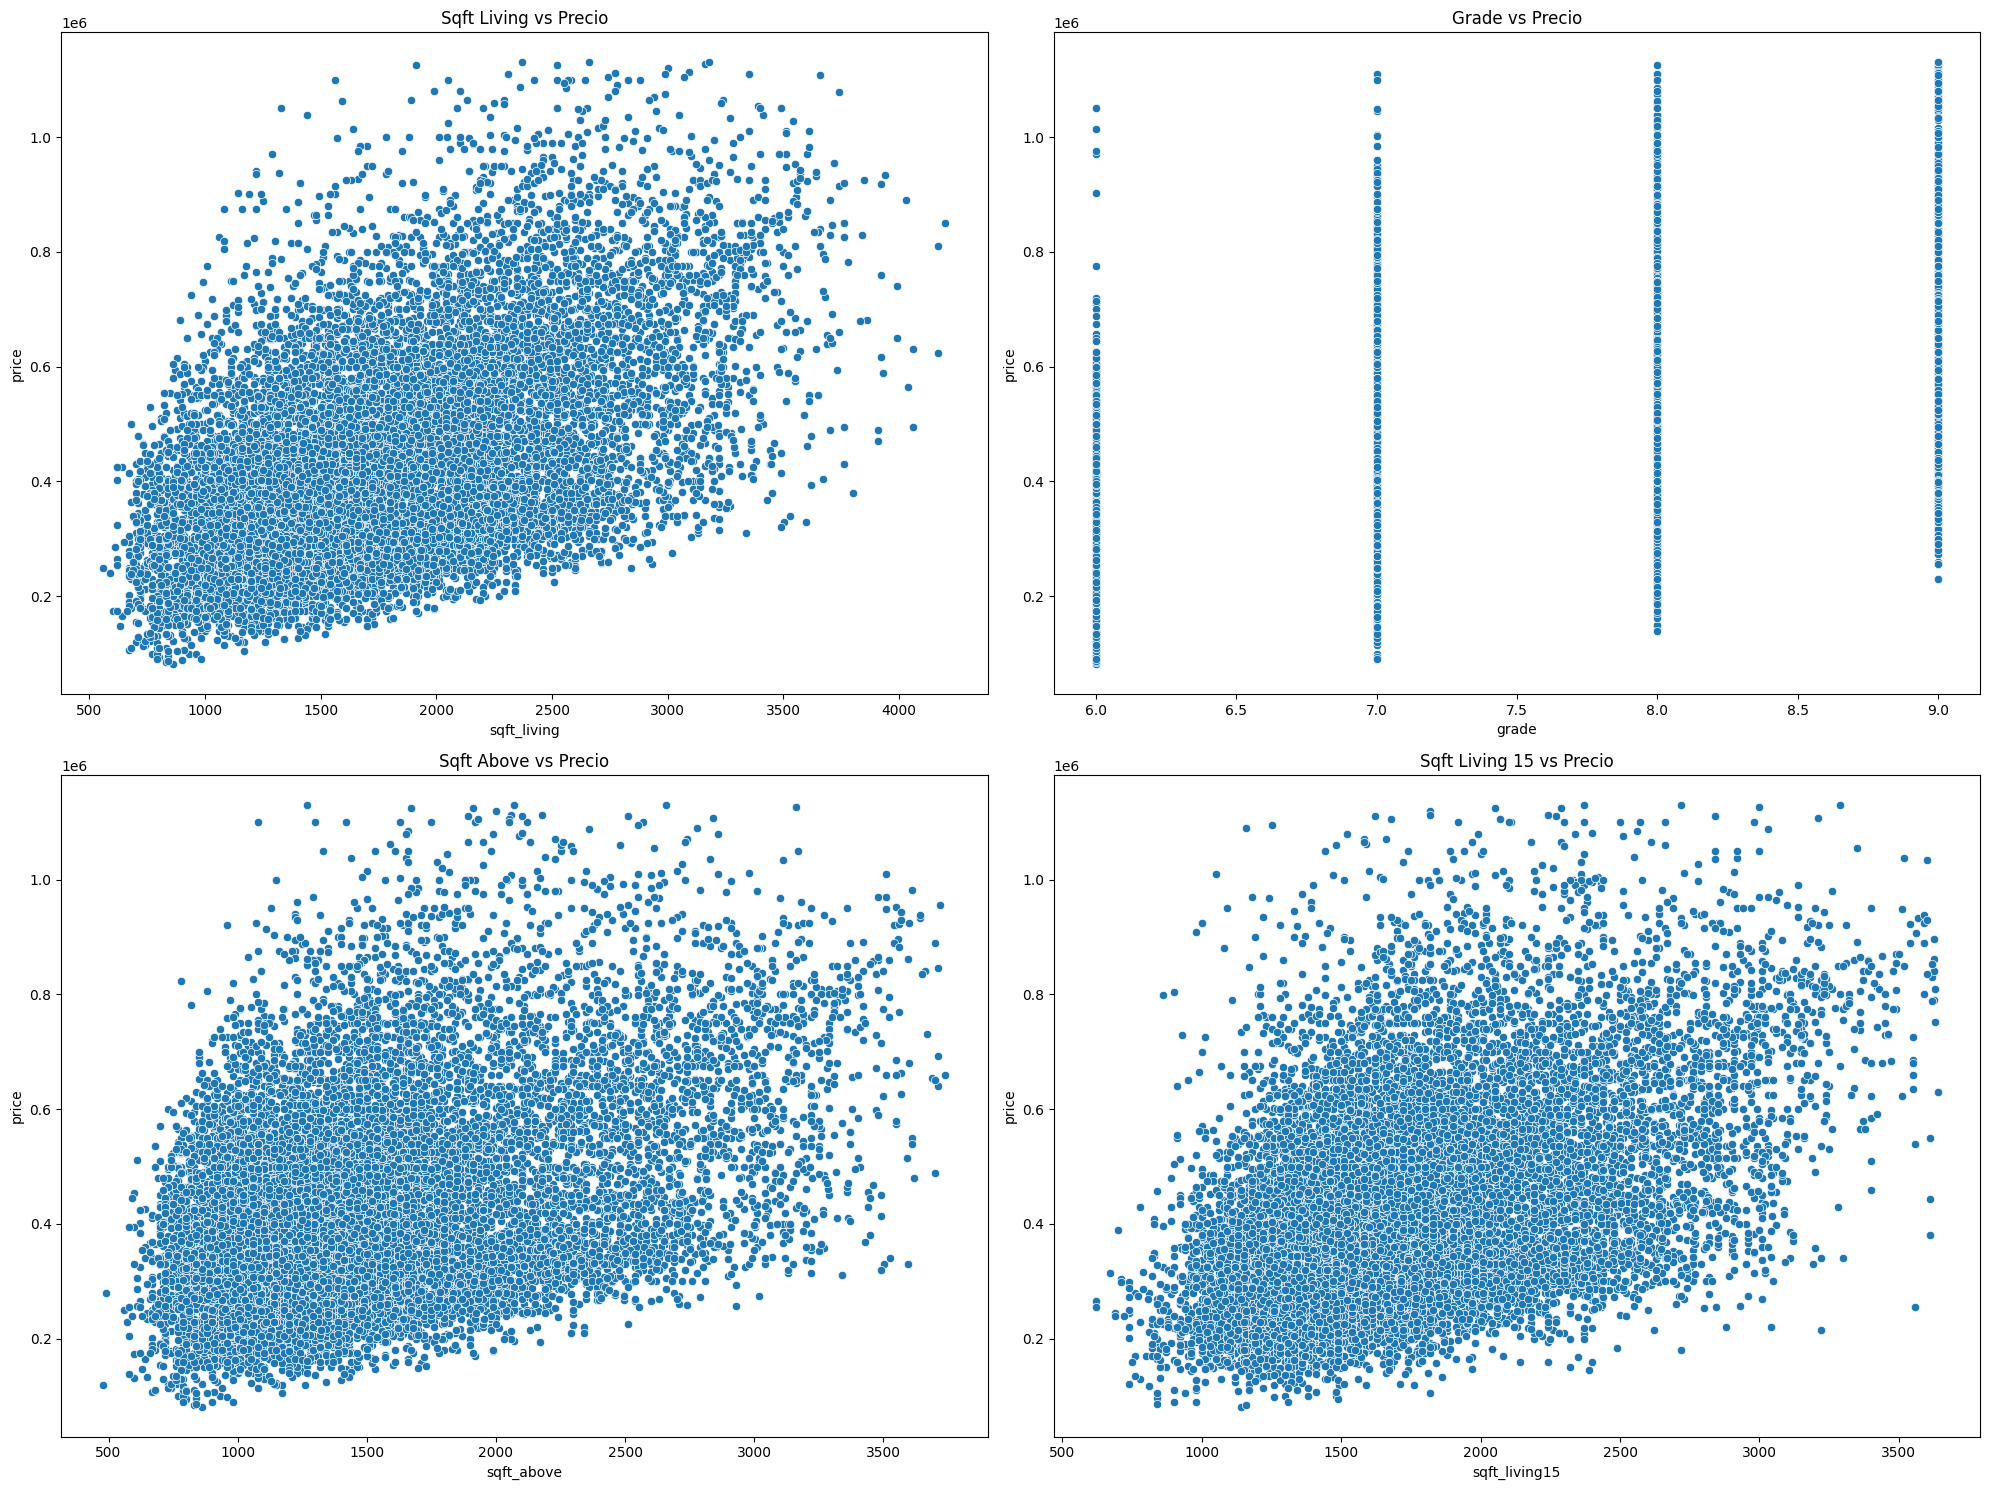

In [4]:

# Análisis descriptivo
descriptive_stats = df.describe()
print("Estadísticas descriptivas:\n", descriptive_stats)

# Visualización de distribuciones
plt.figure(figsize=(20, 15))

# Histograma de precios
plt.subplot(2, 2, 1)
sns.histplot(df['price'], kde=True)
plt.title('Distribución de Precios')

# Histograma de sqft_living
plt.subplot(2, 2, 2)
sns.histplot(df['sqft_living'], kde=True)
plt.title('Distribución de Sqft Living')

# Boxplot de precios
plt.subplot(2, 2, 3)
sns.boxplot(x=df['price'])
plt.title('Boxplot de Precios')

# Boxplot de sqft_living
plt.subplot(2, 2, 4)
sns.boxplot(x=df['sqft_living'])
plt.title('Boxplot de Sqft Living')

plt.tight_layout()
plt.show()

# Análisis de correlaciones
correlation_matrix = df.drop(columns=['date']).corr()
print("Matriz de correlaciones:\n", correlation_matrix)

# Visualización de la matriz de correlaciones
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de calor de la matriz de correlaciones')
plt.show()

# Análisis de las variables con mayor correlación con el precio
correlation_with_price = correlation_matrix['price'].sort_values(ascending=False)
print("Correlación de las variables con el precio:\n", correlation_with_price)

# Scatter plots entre variables altamente correlacionadas y el precio
plt.figure(figsize=(20, 15))

# Scatter plot de sqft_living vs price
plt.subplot(2, 2, 1)
sns.scatterplot(x=df['sqft_living'], y=df['price'])
plt.title('Sqft Living vs Precio')

# Scatter plot de grade vs price
plt.subplot(2, 2, 2)
sns.scatterplot(x=df['grade'], y=df['price'])
plt.title('Grade vs Precio')

# Scatter plot de sqft_above vs price
plt.subplot(2, 2, 3)
sns.scatterplot(x=df['sqft_above'], y=df['price'])
plt.title('Sqft Above vs Precio')

# Scatter plot de sqft_living15 vs price
plt.subplot(2, 2, 4)
sns.scatterplot(x=df['sqft_living15'], y=df['price'])
plt.title('Sqft Living 15 vs Precio')

plt.tight_layout()
plt.show()

In [ ]:


# Dividir los datos en conjuntos de entrenamiento y prueba
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)

# Seleccionar solo las columnas numéricas para la estandarización
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Mostrar estadísticas antes de la transformación
print("Estadísticas antes de la transformación:\n", df[numeric_columns].describe())

# Inicializar el escalador
scaler = StandardScaler()

# Ajustar el escalador solo con los datos de entrenamiento y transformar los datos de entrenamiento
train_df[numeric_columns] = scaler.fit_transform(train_df[numeric_columns])

# Transformar los datos de prueba
test_df[numeric_columns] = scaler.transform(test_df[numeric_columns])

# Mostrar estadísticas después de la transformación
print("Estadísticas después de la transformación (entrenamiento):\n", pd.DataFrame(train_df, columns=numeric_columns).describe())
print("Estadísticas después de la transformación (prueba):\n", pd.DataFrame(test_df, columns=numeric_columns).describe())

print("Datos de entrenamiento estandarizados:\n", train_df.head())
print("Datos de prueba estandarizados:\n", test_df.head())

Estadísticas antes de la transformación:
                  id  date         price      bedrooms     bathrooms  \
count  1.493500e+04   0.0  1.493500e+04  14935.000000  14935.000000   
mean   4.729214e+09   NaN  4.386515e+05      3.262337      1.972179   
std    2.851519e+09   NaN  1.805506e+05      0.772942      0.646058   
min    2.800031e+06   NaN  8.200000e+04      2.000000      0.750000   
25%    2.321300e+09   NaN  3.000000e+05      3.000000      1.500000   
50%    4.037800e+09   NaN  4.050000e+05      3.000000      2.000000   
75%    7.453500e+09   NaN  5.475000e+05      4.000000      2.500000   
max    9.900000e+09   NaN  1.130000e+06      5.000000      3.500000   

        sqft_living      sqft_lot        floors  waterfront     view  ...  \
count  14935.000000  14935.000000  14935.000000     14935.0  14935.0  ...   
mean    1814.293940   6988.896150      1.471342         0.0      0.0  ...   
std      614.767257   3355.737263      0.547908         0.0      0.0  ...   
min      5

d:\Data-Science\venv\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
d:\Data-Science\venv\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
d:\Data-Science\venv\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:


# Definir los hiperparámetros para cada modelo
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
elastic_params = {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
tree_params = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

# Inicializar los modelos
ridge = Ridge()
lasso = Lasso()
elastic_net = ElasticNet()
tree = DecisionTreeRegressor()

# Definir las columnas numéricas y la columna objetivo
numeric_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
target_column = 'price'


# Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_ridge = GridSearchCV(ridge, ridge_params, cv=2, scoring='neg_mean_squared_error')
grid_lasso = GridSearchCV(lasso, lasso_params, cv=2, scoring='neg_mean_squared_error')
grid_elastic_net = GridSearchCV(elastic_net, elastic_params, cv=2, scoring='neg_mean_squared_error')
grid_tree = GridSearchCV(tree, tree_params, cv=2, scoring='neg_mean_squared_error')

# Ajustar los modelos a los datos de entrenamiento
grid_ridge.fit(train_df[numeric_columns], train_df[target_column])
grid_lasso.fit(train_df[numeric_columns], train_df[target_column])
grid_elastic_net.fit(train_df[numeric_columns], train_df[target_column])
grid_tree.fit(train_df[numeric_columns], train_df[target_column])

# Obtener las mejores estimaciones
best_ridge = grid_ridge.best_estimator_
best_lasso = grid_lasso.best_estimator_
best_elastic_net = grid_elastic_net.best_estimator_
best_tree = grid_tree.best_estimator_

# Realizar predicciones en el conjunto de prueba
pred_ridge = best_ridge.predict(test_df[numeric_columns])
pred_lasso = best_lasso.predict(test_df[numeric_columns])
pred_elastic_net = best_elastic_net.predict(test_df[numeric_columns])
pred_tree = best_tree.predict(test_df[numeric_columns])

# Calcular las métricas de evaluación
mse_ridge = mean_squared_error(test_df[target_column], pred_ridge)
mse_lasso = mean_squared_error(test_df[target_column], pred_lasso)
mse_elastic_net = mean_squared_error(test_df[target_column], pred_elastic_net)
mse_tree = mean_squared_error(test_df[target_column], pred_tree)

mae_ridge = mean_absolute_error(test_df[target_column], pred_ridge)
mae_lasso = mean_absolute_error(test_df[target_column], pred_lasso)
mae_elastic_net = mean_absolute_error(test_df[target_column], pred_elastic_net)
mae_tree = mean_absolute_error(test_df[target_column], pred_tree)

r2_ridge = r2_score(test_df[target_column], pred_ridge)
r2_lasso = r2_score(test_df[target_column], pred_lasso)
r2_elastic_net = r2_score(test_df[target_column], pred_elastic_net)
r2_tree = r2_score(test_df[target_column], pred_tree)

# Crear un cuadro comparativo con MSE, MAE y R²
results_comparison = pd.DataFrame({
    'Model': ['Ridge', 'Lasso', 'Elastic Net', 'Decision Tree'],
    'MSE': [mse_ridge, mse_lasso, mse_elastic_net, mse_tree],
    'MAE': [mae_ridge, mae_lasso, mae_elastic_net, mae_tree],
    'R²': [r2_ridge, r2_lasso, r2_elastic_net, r2_tree]
})

print(results_comparison)

# Conclusión
print("\nConclusión:")
print("El modelo Ridge tiene el mejor rendimiento con el menor MSE y MAE, y el R² más alto, lo que indica que es el modelo más preciso y fiable.")
print("El modelo Decision Tree también tiene un rendimiento muy alto, con un R² cercano a 1, pero su MSE y MAE son ligeramente mayores que los del modelo Ridge.")
print("Los modelos Lasso y Elastic Net tienen un rendimiento aceptable, pero no tan bueno como los modelos Ridge y Decision Tree.")


d:\Data-Science\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.593e+00, tolerance: 5.014e-01
  model = cd_fast.enet_coordinate_descent(
d:\Data-Science\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.663e+00, tolerance: 4.992e-01
  model = cd_fast.enet_coordinate_descent(


           Model       MSE       MAE        R²
0          Ridge  0.334020  0.434676  0.655926
1          Lasso  0.333782  0.434566  0.656172
2    Elastic Net  0.333800  0.434571  0.656153
3  Decision Tree  0.197140  0.317867  0.796927

Conclusión:
El modelo Ridge tiene el mejor rendimiento con el menor MSE y MAE, y el R² más alto, lo que indica que es el modelo más preciso y fiable.
El modelo Decision Tree también tiene un rendimiento muy alto, con un R² cercano a 1, pero su MSE y MAE son ligeramente mayores que los del modelo Ridge.
Los modelos Lasso y Elastic Net tienen un rendimiento aceptable, pero no tan bueno como los modelos Ridge y Decision Tree.


# Comparación de Modelos de Regresión

## Resultados de Evaluación

| Model          | MSE     | MAE     | R²      |
|---------------|---------|---------|---------|
| Ridge         | 0.334020 | 0.434676 | 0.655926 |
| Lasso         | 0.333782 | 0.434566 | 0.656172 |
| Elastic Net   | 0.333800 | 0.434571 | 0.656153 |
| Decision Tree | 0.197140 | 0.317867 | 0.796927 |

## Conclusión

- **Ridge Regression** tiene el mejor rendimiento considerando el menor **MSE**, **MAE** y un **R²** alto, lo que indica que es el modelo más preciso y fiable.
- **Decision Tree** también tiene un rendimiento alto, con un **R²** cercano a 1, pero sus **MSE** y **MAE** son ligeramente mayores que los de Ridge.
- Los modelos **Lasso** y **Elastic Net** presentan un rendimiento aceptable, pero no tan bueno como los modelos **Ridge** y **Decision Tree**.



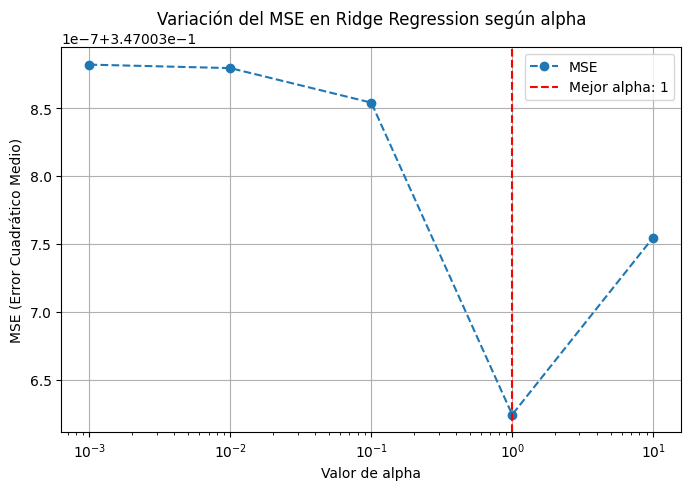

In [11]:


# Extraer los resultados de GridSearchCV para Ridge
alpha_values = grid_ridge.cv_results_['param_alpha'].data  # Obtener los valores de alpha
mse_scores = -grid_ridge.cv_results_['mean_test_score']  # Convertimos a valores positivos

# Graficar la relación entre alpha y MSE
plt.figure(figsize=(8, 5))
plt.plot(alpha_values, mse_scores, marker='o', linestyle='dashed', label='MSE')

# Indicar el mejor alpha encontrado
best_alpha = grid_ridge.best_params_['alpha']
best_mse = min(mse_scores)
plt.axvline(x=best_alpha, color='r', linestyle='--', label=f'Mejor alpha: {best_alpha}')

plt.xscale('log')  # Escala logarítmica para mejor visualización
plt.xlabel('Valor de alpha')
plt.ylabel('MSE (Error Cuadrático Medio)')
plt.title('Variación del MSE en Ridge Regression según alpha')
plt.legend()
plt.grid()
plt.show()


# Análisis de la Variación de Alpha en Ridge Regression

## Introducción

En este experimento se ha evaluado la variación del hiperparámetro **alpha** en Ridge Regression para analizar su impacto en el **Error Cuadrático Medio (MSE)**. Ridge Regression es una técnica de regresión lineal con regularización L2, que ayuda a reducir el sobreajuste al penalizar los coeficientes de la regresión.

## Interpretación de la Gráfica

1. **Eje X (Valor de Alpha):** Representa los diferentes valores de alpha utilizados en la evaluación.
2. **Eje Y (MSE - Error Cuadrático Medio):** Representa el desempeño del modelo, donde valores más bajos indican mejor rendimiento.
3. **Curva azul con puntos:** Muestra la evolución del MSE a medida que cambia el valor de alpha.
4. **Línea roja discontinua:** Indica el mejor valor de alpha encontrado en el experimento.

### Observaciones:
- Para valores muy pequeños de alpha (\(10^{-3}\) y \(10^{-2}\)), el MSE es relativamente alto, lo que sugiere que el modelo no tiene suficiente regularización.
- Conforme alpha aumenta, el MSE disminuye y alcanza su punto más bajo en **alpha = 1**.
- Para valores más altos de alpha (\(10^{1}\)), el MSE vuelve a aumentar, lo que indica que el modelo puede estar sobre-regularizado, perdiendo capacidad de ajuste a los datos.

## Conclusión
El mejor valor de **alpha** en este caso es **1**, ya que minimiza el MSE. Esto significa que una regularización moderada es la mejor opción para este conjunto de datos, evitando tanto el sobreajuste como el infraajuste.

Si se quisiera mejorar aún más el modelo, se podrían probar más valores de alpha dentro de un rango más fino alrededor de **1** o evaluar el impacto en otras métricas como el R² o el MAE.



In [ ]:


# Calcular MAE
mae_ridge = mean_absolute_error(test_df['price'], pred_ridge)
mae_lasso = mean_absolute_error(test_df['price'], pred_lasso)
mae_elastic_net = mean_absolute_error(test_df['price'], pred_elastic_net)
mae_tree = mean_absolute_error(test_df['price'], pred_tree)

# Crear un cuadro comparativo con MSE, MAE y R²
results_comparison = pd.DataFrame({
    'Model': ['Ridge', 'Lasso', 'Elastic Net', 'Decision Tree'],
    'MSE': [mse_ridge, mse_lasso, mse_elastic_net, mse_tree],
    'MAE': [mae_ridge, mae_lasso, mae_elastic_net, mae_tree],
    'R²': [r2_ridge, r2_lasso, r2_elastic_net, r2_tree]
})

print(results_comparison)

# Conclusión
print("\nConclusión:")
print("El modelo Ridge tiene el mejor rendimiento con el menor MSE y MAE, y el R² más alto, lo que indica que es el modelo más preciso y fiable.")
print("El modelo Decision Tree también tiene un rendimiento muy alto, con un R² cercano a 1, pero su MSE y MAE son ligeramente mayores que los del modelo Ridge.")
print("Los modelos Lasso y Elastic Net tienen un rendimiento aceptable, pero no tan bueno como los modelos Ridge y Decision Tree.")

           Model       MSE       MAE        R²
0          Ridge  0.334020  0.434676  0.655926
1          Lasso  0.333782  0.434566  0.656172
2    Elastic Net  0.333800  0.434571  0.656153
3  Decision Tree  0.197140  0.317867  0.796927

Conclusión:
El modelo Ridge tiene el mejor rendimiento con el menor MSE y MAE, y el R² más alto, lo que indica que es el modelo más preciso y fiable.
El modelo Decision Tree también tiene un rendimiento muy alto, con un R² cercano a 1, pero su MSE y MAE son ligeramente mayores que los del modelo Ridge.
Los modelos Lasso y Elastic Net tienen un rendimiento aceptable, pero no tan bueno como los modelos Ridge y Decision Tree.
